In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
import datetime as dt
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

# Import Matplot lib
import matplotlib
from matplotlib import style
style.use('seaborn-pastel')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
# Create Database Connection
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)
#or engine.connect, but always use Session(engine)
#pandas.read or write sql - look this up and read doc

# Exploratory Climate Analysis

In [7]:
# Identify most recent date 
session.query(func.max(Measurement.date)).all()

[('2017-08-23')]

In [8]:
# edgar
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#session.query(func.max(Measurement.date)).all()
results = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date <= '2017-08-23').\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date.desc()).all()

pd.DataFrame(results).head(5)


,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


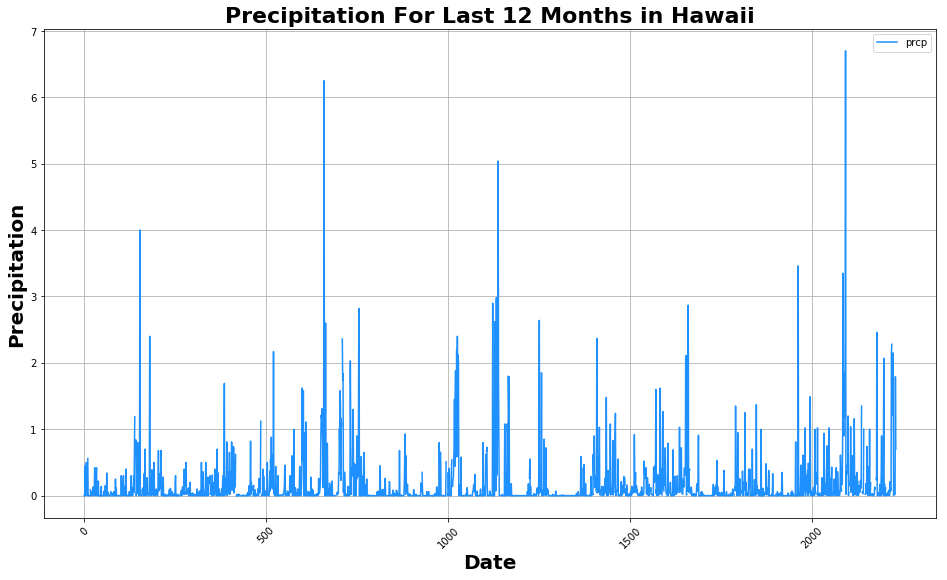

In [9]:
# Load and save the results into a pandas dataframe. 
prec_df = pd.DataFrame(results)

#Plot Precipitation for the lat 12 months using Matplotlib

prec_plot = prec_df.plot(figsize = (16, 9), sort_columns=True, rot=45, use_index=True, legend=True, grid=True, color='dodgerblue')
plt.ylabel('Precipitation', weight='bold', fontsize=20)
plt.xlabel('Date', weight='bold', fontsize=20)
plt.title("Precipitation For Last 12 Months in Hawaii",weight='bold', fontsize=22)
plt.show()


In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station.id).count()
station_num

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active_station = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
    filter(Measurement.station == Station.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

In [13]:
most_active_station
#I wasn't sure how many to show, but Waihee has highest number of observations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
waihee_tobs = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
              filter(Measurement.station == "USC00519281").all()
waihee_tobs

[(54.0, 85.0, 71.66378066378067)]

In [15]:
temperatures = [temp[0] for temp in waihee_tobs]
temperatures

[54.0]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.tobs).\
              filter(Measurement.station == "USC00519281").\
              filter(Measurement.date >= '2016-08-23').all()

most_active_station_df = pd.DataFrame(most_active_station, columns=["Temperature"])
most_active_station_df.describe()


,Temperature
count,352.000000
mean,73.107955
std,4.733315
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


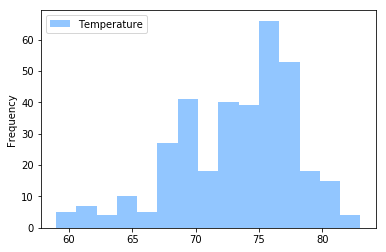

In [17]:
most_active_station_df.plot.hist(bins=15, range=[59,83])

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-01-01', '2017-01-15')
trip_data = list(np.ravel(trip_temps))
trip_data

[60.0, 68.5505617977528, 81.0]

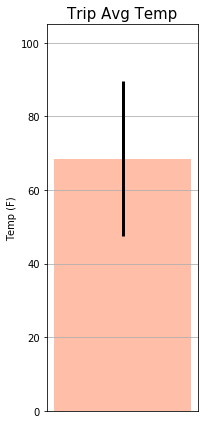

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_avg = trip_data[1]
peak = [trip_data[2] - trip_data[0]]

# Create Arrays for the plot
x = 1
y = temp_avg
error = peak

# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(3,6) 
ax.bar(x, y, yerr=error, align='center', color="coral", alpha=0.5, width=.50, error_kw=dict(elinewidth=3))

ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp', fontsize=15)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.set_ylim(0, 105)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Save the figure and show
plt.tight_layout()
plt.show()

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
select = [Measurement.station, Station.name,  Station.latitude, Station.longitude, \
       Station.elevation, func.sum(Measurement.prcp)]

rainfall_trip_dates = session.query(*select).filter(Measurement.station == Station.station).\
                      filter(Measurement.date >= "2016-01-01").\
                      filter(Measurement.date <= "2016-01-15").\
                      group_by(Measurement.station).\
                      order_by (func.sum(Measurement.prcp).desc()).all()

print(rainfall_trip_dates)



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.9400000000000004), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.03), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6900000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.6100000000000001), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.23), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.13), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    select = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*select).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
daterange = pd.date_range("2017-01-01", "2017-01-15")

trip_dates = []

for single_date in daterange:
    day = (single_date.strftime("%m-%d"))
    trip_dates.append(day)

#Use the daily_normals function to calculate the normals for each date string and append the results to a list.

daily_normal_trip_dates = []

for date in trip_dates:
    new_list = daily_normals(date)
    daily_normal_trip_dates.append(new_list)

daily_normal_trip_dates


[[(62.0, 69.15384615384616, 77.0)],
 [(60.0, 69.39622641509433, 77.0)],
 [(62.0, 68.9090909090909, 77.0)],
 [(58.0, 70.0, 76.0)],
 [(56.0, 67.96428571428571, 76.0)],
 [(61.0, 68.96491228070175, 76.0)],
 [(57.0, 68.54385964912281, 76.0)],
 [(57.0, 67.16071428571429, 75.0)],
 [(58.0, 67.9298245614035, 78.0)],
 [(62.0, 69.74137931034483, 77.0)],
 [(57.0, 67.3103448275862, 78.0)],
 [(57.0, 67.4074074074074, 81.0)],
 [(57.0, 67.25454545454545, 77.0)],
 [(58.0, 69.52631578947368, 77.0)],
 [(56.0, 69.31372549019608, 78.0)]]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_query = []
for x in daily_normal_trip_dates:
    trip_query.append([element for tupl in x for element in tupl])
    
trip_query

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0],
 [56.0, 69.31372549019608, 78.0]]

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
dn_df = pd.DataFrame(trip_query, columns=["tmin", "tavg", "tmax"])
dn_df.insert(3, "Year", "2018")
dn_df.insert(4,"days", trip_dates)
dn_df.head()

,tmin,tavg,tmax,Year,days
0,62.0,69.153846,77.0,2018,01-01
1,60.0,69.396226,77.0,2018,01-02
2,62.0,68.909091,77.0,2018,01-03
3,58.0,70.000000,76.0,2018,01-04
4,56.0,67.964286,76.0,2018,01-05


In [26]:
dn_df["date"] = dn_df["Year"].map(str) + '-' + dn_df['days'].map(str)
dn_df.set_index(["date"], inplace=True)
dn_df.drop(dn_df.columns[[3, 4]], axis=1, inplace=True)
dn_df.head()

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


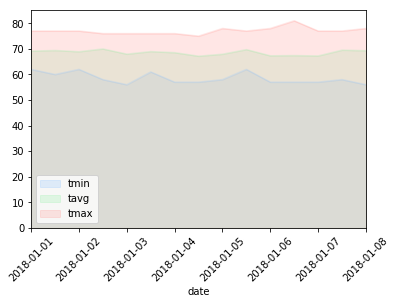

In [27]:
ax = dn_df.plot(kind='area', stacked=False, alpha=.25)
x_labels = dn_df.index
ax.set_xticklabels(x_labels, rotation=45)
ax.margins(0, 0) # Set margins to avoid "whitespace"

plt.show()